In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import typing as t

from pathlib import Path

sns.set_style("ticks", rc={"axes.grid": True})

datadir = Path("../results_round_2/")
outdir = Path("out")

model_code_to_str = {
    0: "DebugNet",
    1: "KyleNet",
    18: "ResNet-18",
    50: "ResNet-50",
    152: "ResNet-152",
}

model_order = ["DebugNet", "KyleNet", "ResNet-18", "ResNet-50", "ResNet-152"]

# Step 1: Data Parsing

In [4]:
def filter_results(datadir) -> t.Iterator[Path]:
    mask = "❯ Finished in"
    for file in datadir.glob("*.stdout"):
        with open(file, "r") as f:
            text = f.read()
            if mask in text:
                yield file

In [5]:
for f in filter_results(datadir):
    print(f)

../results_round_2/run_multinode_1.128.stdout
../results_round_2/run_multinode_0.8.stdout
../results_round_2/run_multinode_18.128.stdout
../results_round_2/run_multinode_152.2.stdout
../results_round_2/run_multinode_50.2.stdout
../results_round_2/run_multinode_50.64.stdout
../results_round_2/run_multinode_0.2.stdout
../results_round_2/run_multinode_1.2.stdout
../results_round_2/run_multinode_0.64.stdout
../results_round_2/run_multinode_50.8.stdout
../results_round_2/run_multinode_50.4.stdout
../results_round_2/run_multinode_152.8.stdout
../results_round_2/run_multinode_152.4.stdout
../results_round_2/run_multinode_0.512.stdout
../results_round_2/run_multinode_1.1024.stdout
../results_round_2/run_multinode_1.16.stdout
../results_round_2/run_multinode_1.32.stdout
../results_round_2/run_multinode_0.128.stdout
../results_round_2/run_multinode_0.256.stdout
../results_round_2/run_multinode_0.1024.stdout
../results_round_2/run_multinode_0.16.stdout
../results_round_2/run_multinode_0.32.stdout

In [20]:
def parse_file_to_record(file: Path) -> dict[str, float]:
    record = {}
    
    # Infer the experiment setup from the filename.
    stem = file.stem
    stem = stem.split("_")[-1]
    model_num, num_workers = stem.split(".")
    model_num, num_workers = int(model_num), int(num_workers)
    record["model"] = model_code_to_str[model_num]
    record["num_workers"] = num_workers
    
    # Extract the results from the stdout data.
    with open(file, "r") as f:
        for line in f.readlines():
            if line.startswith("start:"):
                value = line.split(":")[-1]
                value = float(value)
                record["start"] = value
            
            elif line.startswith("dfk_start_done:"):
                value = line.split(":")[-1]
                value = float(value)
                record["dfk_start_done"] = value
            
            elif line.startswith("priming_done:"):
                value = line.split(":")[-1]
                value = float(value)
                record["priming_done"] = value
                
            elif line.startswith("end:"):
                value = line.split(":")[-1]
                value = float(value)
                record["end"] = value
    
    return record

def parse_files_to_df(datadir) -> pd.DataFrame:
    records: list[dict[str, float]] = [
        parse_file_to_record(file)
        for file in filter_results(datadir)
    ]
    df = pd.DataFrame.from_records(records)
    df["start2end"] = df.end - df.start
    df["dfk2end"] = df.end - df.dfk_start_done 
    df["prime2end"] = df.end - df.priming_done
    return df

In [21]:
df = parse_files_to_df(datadir)
df.head()

,model,num_workers,start,dfk_start_done,priming_done,end,start2end,dfk2end,prime2end
0,KyleNet,128,3.909379e+06,3.909403e+06,3.909506e+06,3.909518e+06,139.629583,115.433736,12.780831
1,DebugNet,8,8.849040e+06,8.849055e+06,8.849059e+06,8.849062e+06,21.715031,6.760647,2.422026
2,ResNet-18,128,3.909522e+06,3.909546e+06,3.909647e+06,3.909802e+06,279.630127,255.219570,154.239275
3,ResNet-152,2,1.327758e+06,1.327774e+06,1.327779e+06,1.327797e+06,38.669392,23.435576,18.257366
4,ResNet-50,2,1.349776e+07,1.349778e+07,1.349778e+07,1.349779e+07,29.467223,14.432628,9.470392


# Step 2: Data Visualization

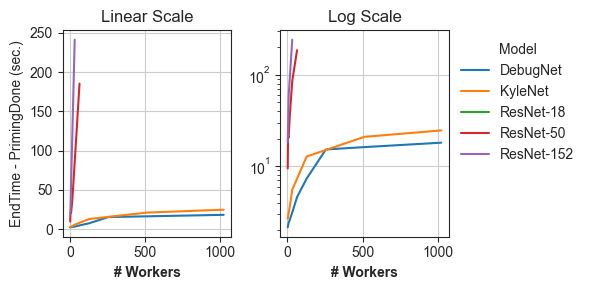

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
sns.lineplot(
    df,
    x="num_workers",
    y="prime2end",
    hue="model",
    hue_order=model_order,
    ax=ax[0],
).set(yscale="linear")

sns.lineplot(
    df,
    x="num_workers",
    y="prime2end",
    hue="model",
    hue_order=model_order,
    ax=ax[1],
).set(yscale="log")

ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1, 1), title="Model", frameon=False)

ax[0].set_ylabel("EndTime - PrimingDone (sec.)")
ax[1].set_ylabel("")

ax[0].set_xlabel("# Workers", weight="bold")
ax[1].set_xlabel("# Workers", weight="bold")

ax[0].set_title("Linear Scale")
ax[1].set_title("Log Scale")

plt.tight_layout()
plt.savefig(outdir / "end_prime.pdf", bbox_inches="tight")
plt.show()

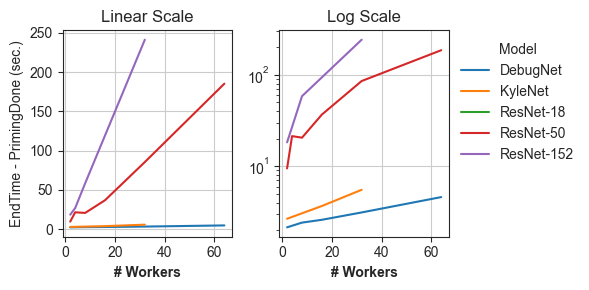

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
sns.lineplot(
    df.query("num_workers < 128"),
    x="num_workers",
    y="prime2end",
    hue="model",
    hue_order=model_order,
    ax=ax[0],
).set(yscale="linear")

sns.lineplot(
    df.query("num_workers < 128"),
    x="num_workers",
    y="prime2end",
    hue="model",
    hue_order=model_order,
    ax=ax[1],
).set(yscale="log")

ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1, 1), title="Model", frameon=False)

ax[0].set_ylabel("EndTime - PrimingDone (sec.)")
ax[1].set_ylabel("")

ax[0].set_xlabel("# Workers", weight="bold")
ax[1].set_xlabel("# Workers", weight="bold")

ax[0].set_title("Linear Scale")
ax[1].set_title("Log Scale")

plt.tight_layout()
plt.savefig(outdir / "end_prime__zoomed_in.pdf", bbox_inches="tight")
plt.show()